# Overview:  HW3 - Question 4

In this coding question, you'll implement a classifier with logistic regression
$$ F(w) = \frac{1}{N} \sum_{i=1}^N \log( 1 + e^{-\langle w, x_i \rangle y_i} ). $$

For this problem, I would suggest using functions to prepare the dataset, run gradient descent, and return classification error.  By doing this, you only have to write the code one time and just use the functions to return results for part (4c).

# Loading MNIST Data

In this section, you will learn to load MNIST data.  If you do not have tensorflow available on your jupyter notebook, uncomment the next cell, run it, restart the kernel, and comment the next cell once more.

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.datasets import fetch_openml

In [3]:
# test = pd.read_csv('mnist_test.csv', names=[f"x{i}" for i in range(784)] + ["y"])
# train = pd.read_csv('mnist_train.csv', names=[f"x{i}" for i in range(784)] + ["y"])
test = pd.read_csv('mnist_test.csv',header=None)
train = pd.read_csv('mnist_train.csv', header=None)

In [4]:
print(test.shape)
test.head(5)

(10000, 785)


,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
0,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
print(train.shape)
train.head(5)

(60000, 785)


,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
len(train), len(test)

(60000, 10000)

In [7]:
def preprocess(data):
    X = data.iloc[:, 1:]
    y = data.iloc[:, 0]
    digits = {j:[] for j in range(10)}
    for j in range(len(y)):
        cur_label = int(y[j])
        cur_pixel_data = np.array(X.iloc[j]).reshape(28,28)
        digits[cur_label].append(cur_pixel_data)
    digits = {j:np.stack(digits[j]) for j in range(10)}
    for j in range(10):
        print('shape of data with label', j, ':', digits[j].shape)
    
    return digits

In [8]:
train_digits = preprocess(train)

shape of data with label 0 : (5923, 28, 28)
shape of data with label 1 : (6742, 28, 28)
shape of data with label 2 : (5958, 28, 28)
shape of data with label 3 : (6131, 28, 28)
shape of data with label 4 : (5842, 28, 28)
shape of data with label 5 : (5421, 28, 28)
shape of data with label 6 : (5918, 28, 28)
shape of data with label 7 : (6265, 28, 28)
shape of data with label 8 : (5851, 28, 28)
shape of data with label 9 : (5949, 28, 28)


In [9]:
test_digits = preprocess(test)

shape of data with label 0 : (980, 28, 28)
shape of data with label 1 : (1135, 28, 28)
shape of data with label 2 : (1032, 28, 28)
shape of data with label 3 : (1010, 28, 28)
shape of data with label 4 : (982, 28, 28)
shape of data with label 5 : (892, 28, 28)
shape of data with label 6 : (958, 28, 28)
shape of data with label 7 : (1028, 28, 28)
shape of data with label 8 : (974, 28, 28)
shape of data with label 9 : (1009, 28, 28)


# (4a) Plotting

Display one randomly selected image from your training data for each digit class. Provide the index number for each image.

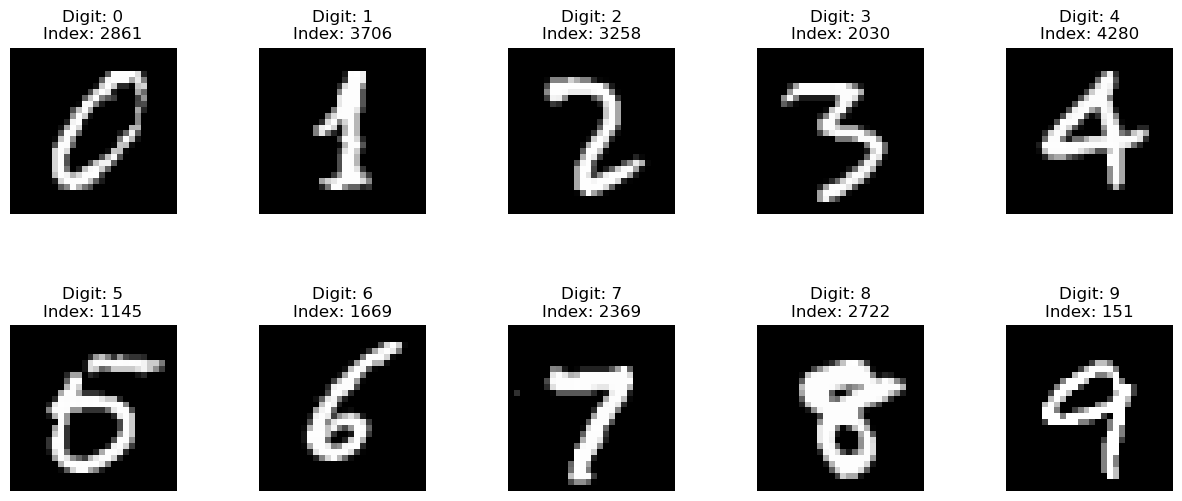

In [12]:
import random

def display_random_images(digits_data):
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    fig.subplots_adjust(hspace=0.5, wspace=0.5)

    for i in range(10):
        ax = axes[i // 5, i % 5]
        index = random.randint(0, digits_data[i].shape[0] - 1)
        image = digits_data[i][index]
        
        ax.imshow(image, cmap='gray')
        ax.set_title(f'Digit: {i}\nIndex: {index}')
        ax.axis('off')

    plt.show()
    
display_random_images(train_digits)

# (4b) Label data

Select the first 500 examples of 0’s and 1’s for this example, those will form the training data $(x_i , y_i) \in \mathbb{R}^{784} \times \{−1,1\}, i = 1,...,1000$. Assign label $y_i = 1$ for 1s and $y_i = −1$ for 0s.  You can use __np.vectorize__ here.

In [11]:
train_zero_data = train_digits[0]
train_one_data = train_digits[1]

train_zero_labels = np.ones(len(train_zero_data))*-1
train_one_labels = np.ones(len(train_one_data))

train_zero_data = np.reshape(train_zero_data, (len(train_zero_data), 28*28))
train_one_data = np.reshape(train_one_data, (len(train_one_data), 28*28))

train_zero_data.shape

(5923, 784)

In [12]:
train_zero_data = train_zero_data[:500]
train_one_data = train_one_data[:500]

train_zero_labels = train_zero_labels[:500]
train_one_labels = train_one_labels[:500]

train_data = np.concatenate((train_zero_data, train_one_data))
train_labels = np.concatenate((train_zero_labels, train_one_labels))

train_data.shape, train_labels.shape

((1000, 784), (1000,))

In [13]:
test_zero_data = test_digits[0]
test_one_data = test_digits[1]

test_zero_labels = np.ones(len(test_zero_data))*-1
test_one_labels = np.ones(len(test_one_data))

test_zero_data = np.reshape(test_zero_data, (len(test_zero_data), 28*28))
test_one_data = np.reshape(test_one_data, (len(test_one_data), 28*28))

test_zero_data.shape

(980, 784)

In [14]:
test_zero_data = test_zero_data[:500]
test_one_data = test_one_data[:500]

test_zero_labels = test_zero_labels[:500]
test_one_labels = test_one_labels[:500]

test_data = np.concatenate((test_zero_data, test_one_data))
test_labels = np.concatenate((test_zero_labels, test_one_labels))

test_data.shape, test_labels.shape

((1000, 784), (1000,))

# (4bi) Running Gradient Descent

Implement and run a Gradient Descent algorithm, with step-size $\mu = 10^{-4}$, to optimize the function above associated with this setup. You should run your algorithm for at least $T = 10,000$ iterations, but if your computer can handle it try $T=100,000$ or until a reasonable stopping criterion is satisfied.  Provide a plot showing the value of $F(w)$ at each iteration. Also, feel free to adjust $\mu$ to be larger / smaller if the plot does not match your expectations.

In [15]:
def logistic_loss(w, X, y):
    z = np.dot(X,w)
    log_loss = np.log(1 + np.exp(-y * z))
    log_loss = np.clip(log_loss, a_min=None, a_max=500)
    return np.mean(log_loss)

def logistic_loss_gradient(w, X, y):
    z = np.dot(X, w)
    sigmoid = 1 / (1 + np.exp(-z))
    gradient = np.dot(X.T, (sigmoid - (y==1))) / X.shape[0]
    return gradient

def gradient_descent(X, y, lr, total_epochs, tol):
    w = np.zeros(X.shape[1])
    losses = []
    for epoch in range(total_epochs):
        loss = logistic_loss(w, X, y)
        losses.append(loss)
        gradient = logistic_loss_gradient(w, X, y)
        w = w - lr * gradient

        if np.linalg.norm(gradient) < tol:
            break
    return w, losses


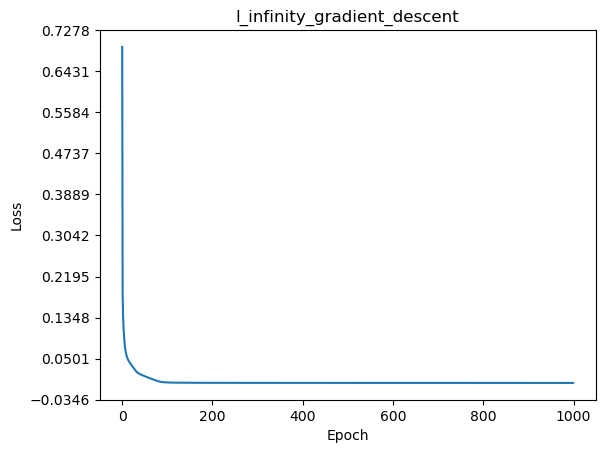

In [20]:
from matplotlib.ticker import LinearLocator

lr = 0.0001
total_epochs = 1000
tol = 0.00001

w, losses = gradient_descent(train_data, train_labels, lr, total_epochs, tol)
# print(w)
# print(gradient)

plt.plot(losses)
plt.title('l_infinity_gradient_descent')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.gca().yaxis.set_major_locator(LinearLocator(numticks=10))

plt.show()
plt.close()

# (4bii) Discussion about gradient descent

Comment on the resulting plot. In particular, does the shape of $F(w)$ suggest you've successfully converged to a local or global minimum?  Does it appear you chose a good stopping criteria?  Explain whether your
answers to these questions are consistent with the theory we discussed in class (and in the
notes). Be specific i.e., point to a specific theorem (or theorems) and indicate
why it does or does not explain the behavior of the algorithm.  Would the theory dictate a different choice of $\mu$ than the one we used?

Put discussion here:
The shape of F(w) shows a successfully converged to a local minimum, since F are convex, continuous, and differentiable. As the iterations increase, the loss of |F(w^(t+1)) - F(w)| approach 0, and the stopping criteria we choose is sufficient as it break the iteration early if gradient equal to zero. Above discover align with our discussion in class about the Sufficient Conditions for Optimization theorems. It explains the behavior of the algorithm since when w* is local min, F(w+h)>=F(w). F(w) should decrease as iterations increase.

# (4biii) 


Now, use the $w$ you found from part (a) to classify the first 500 \emph{test} data points associated to
each of the 0 and 1 handwritten digits. Recall that you need to use the function $y = \text{sign}(w^T x)$
to classify. What was the classification error rate associated with the two digits on the test
data (this should be a number between 0 and 1)? What was it on the training data?  Does this relationship make sense?

In [16]:
def classify(w, X, y):
    y_pred = np.sign(np.dot(X, w))
    return np.mean(y_pred != y)

train_error = classify(w, train_data, train_labels)
test_error = classify(w, test_data, test_labels)

print('Train error: ', train_error)
print('Test error: ', test_error)

Train error:  0.0
Test error:  0.001


# (4c) Repeat with 4s and 9s

Repeat parts (b)i. and (b)iii. for digits of 4s and 9s. Comment on the difference between the results and propose a reason as to why the performance did or did not change.

In [17]:
train_zero_data = train_digits[4]
train_one_data = train_digits[9]

train_zero_labels = np.ones(len(train_zero_data))*-1
train_one_labels = np.ones(len(train_one_data))

train_zero_data = np.reshape(train_zero_data, (len(train_zero_data), 28*28))
train_one_data = np.reshape(train_one_data, (len(train_one_data), 28*28))

train_zero_data = train_zero_data[:500]
train_one_data = train_one_data[:500]

train_zero_labels = train_zero_labels[:500]
train_one_labels = train_one_labels[:500]

train_data = np.concatenate((train_zero_data, train_one_data))
train_labels = np.concatenate((train_zero_labels, train_one_labels))

train_zero_data = train_zero_data[:500]
train_one_data = train_one_data[:500]

train_zero_labels = train_zero_labels[:500]
train_one_labels = train_one_labels[:500]

train_data = np.concatenate((train_zero_data, train_one_data))
train_labels = np.concatenate((train_zero_labels, train_one_labels))

train_data.shape, train_labels.shape

((1000, 784), (1000,))

In [18]:
test_zero_data = test_digits[4]
test_one_data = test_digits[9]

test_zero_labels = np.ones(len(test_zero_data))*-1
test_one_labels = np.ones(len(test_one_data))

test_zero_data = np.reshape(test_zero_data, (len(test_zero_data), 28*28))
test_one_data = np.reshape(test_one_data, (len(test_one_data), 28*28))

test_zero_data = test_zero_data[:500]
test_one_data = test_one_data[:500]

test_zero_labels = test_zero_labels[:500]
test_one_labels = test_one_labels[:500]

test_data = np.concatenate((test_zero_data, test_one_data))
test_labels = np.concatenate((test_zero_labels, test_one_labels))

test_data.shape, test_labels.shape

((1000, 784), (1000,))

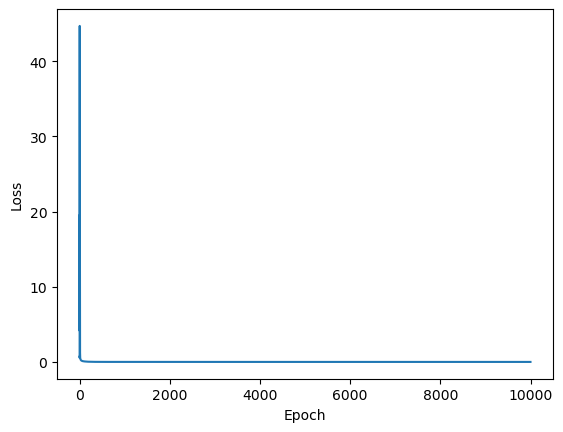

In [21]:
lr = 0.0001
total_epochs = 10000
tol = 0.00001

w, losses = gradient_descent(train_data, train_labels, lr, total_epochs, tol)

plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()
plt.close()

In [63]:
train_error = classify(w, train_data, train_labels)
test_error = classify(w, test_data, test_labels)

print('Train error: ', train_error)
print('Test error: ', test_error)

Train error:  0.0
Test error:  0.06


The shape of resulting plots are similar with larger iterations between 0, 1 and 4, 9. While 4 and 9 have larger losses in the beginning. The classification error on the testing set for 4s and 9s is larger than testing set for 0s and 1s while the error on training set both have 0.0 classification error.

The performance difference may be due to the complexity difference of 2 groups. Since the 0s and 1s are simpler to distinguish while 4s and 9s have higher complexity that result in a larger classification error